# Selección de modelo

# Definiciones

In [1]:
# Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate

In [2]:
# Definiciones globales

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py

# Cargar datos

In [3]:
# Cargar datos ya preprocesados y dividirlos en variables independientes (X) y variable dependiente objetivo (Y)

archivo_datos_codificados = f'{DIRECTORIO_RESULTADOS}/DATOSCODIFICADOS.csv'
df_datos_codificados = pd.read_csv(archivo_datos_codificados, low_memory=False)

X = df_datos_codificados.drop('DETERIORADO', axis='columns')
Y = df_datos_codificados['DETERIORADO']

print('\nVariables de entrada (X):')
print(X.info())
print('-' * 92)
print('\nVariable dependiente (Y):')
print(Y.info())
print(Y.value_counts().sort_index())


Variables de entrada (X):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25674 entries, 0 to 25673
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   EDAD                                 25674 non-null  float64
 1   DIAMETRO                             25674 non-null  float64
 2   LONGITUD                             25674 non-null  float64
 3   AREA                                 25674 non-null  float64
 4   PROF_BATEA                           25674 non-null  float64
 5   PROF_BATE1                           25674 non-null  float64
 6   PENDIENTE                            25674 non-null  float64
 7   ARRANQUE                             25674 non-null  bool   
 8   ZONA_SUR                             25674 non-null  bool   
 9   MUNICIPIO_MEDELLIN                   25674 non-null  bool   
 10  ESTADO_OPERACION                     25674 non-null  bool   
 11  T

# Verificar balance de variable dependiente

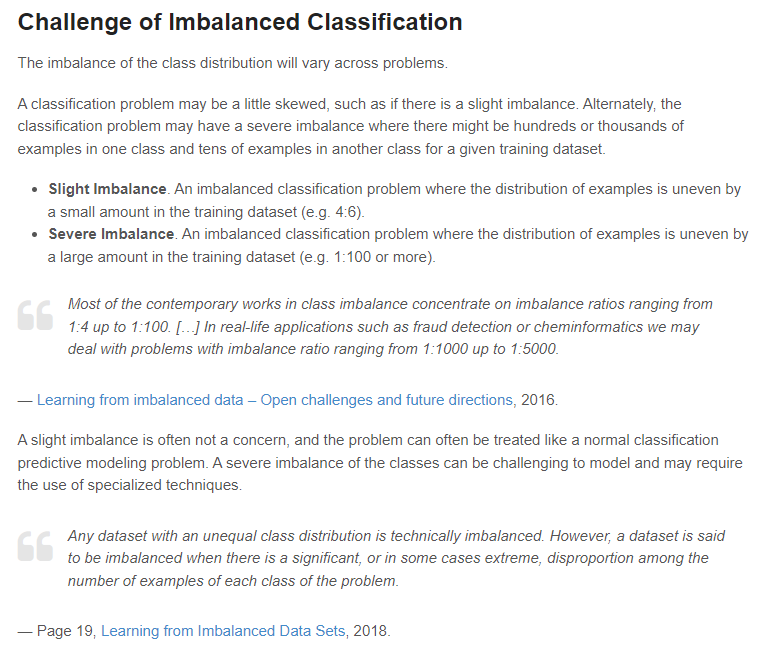

Balance=80.22%, ajuste_prob=30.22%


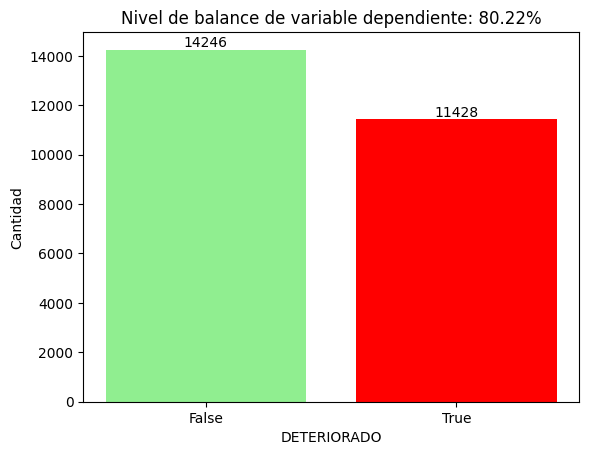

In [4]:
# Verificar balanceo de clase objetivo

conteo = Y.value_counts()
balance = (min(conteo) / max(conteo))
ajuste_prob = .5 - (1 - balance)
print(f'Balance={balance:.2%}, ajuste_prob={ajuste_prob:.2%}')

plt.bar(conteo.index.astype(str), conteo.values, color=['lightgreen', 'red'])
for i, valor in enumerate(conteo.values):
    plt.text(i, valor + 0.1, str(valor), ha='center', va='bottom')

plt.xlabel('DETERIORADO')
plt.ylabel('Cantidad')
plt.title(f'Nivel de balance de variable dependiente: {balance:.2%}')
plt.show()

# Crear estructuras para almacenar modelos y sus resultados

In [5]:
# Definir clase para evaluación de modelos
class EvaluacionModeloML:
    def __init__(self, modelo, param_grid={}):
        self.isTrained = False
        self.modelo = modelo
        self.param_grid = param_grid
        self.best_params = {}
        self.scoresCV = None # Para resultados de cross_validate

# Inicializar diccionario de evaluaciones
dict_evaluaciones = {}

# Rango de balance de clases
class_weights_list = [
    {False: 1,               True: (1 + ajuste_prob)}, 
    {False: (1-ajuste_prob), True: 1},
]

# Configurar modelos candidatos

### Regresión logística

In [6]:
dict_evaluaciones['LGR'] = EvaluacionModeloML(
    modelo = LogisticRegression(),
    param_grid = {
        'C'                      : [2 ],
        'class_weight'           : [class_weights_list[1]],
        #'dual'                   : [False, ],
        #'fit_intercept'          : [True, False, ],
        #'intercept_scaling'      : [1, 0.1, 10, ],
        #'l1_ratio'               : [None, ],
        #'max_iter'               : [100, 1000 ],
        #'multi_class'            : ['auto', ],
        'n_jobs'                 : [-1],
        #'penalty'                : ['l2', None],
        'solver'                 : ['newton-cholesky'],
        #'tol'                    : [0.0001, 1e-05, 0.001, ],
        #'warm_start'             : [True, False],
    }
)

### Support Vector Machine

In [7]:
dict_evaluaciones['SVC'] = EvaluacionModeloML(
    modelo = SVC(),
    param_grid = {
        'C'                      : [20],
        # 'break_ties'             : [False, True, ],
        # 'cache_size'             : [200, 20.0, 2000, ],
        'class_weight'           : [class_weights_list[1]],
        # 'coef0'                  : [0.0, ],
        # 'decision_function_shape': ['ovr', ],
        #'degree'                 : [3, 4],
        #'gamma'                  : ['scale'], 
        #'kernel'                 : ['rbf', 'poly', 'sigmoid'], 
        # 'max_iter'               : [-1, -0.1, -10, ],
        # 'probability'            : [False, True, ],
        # 'shrinking'              : [True, False, ],
        # 'tol'                    : [0.001, 0.0001, 0.01, ],
    }
)

### Random Forest Classifier

In [8]:
dict_evaluaciones['RFC'] = EvaluacionModeloML(
    modelo = RandomForestClassifier(),
    param_grid = {
        #'bootstrap'              : [False, ],
        'ccp_alpha'              : [0.05],   # very sensitive. valor alto -> recall 1.0
        'class_weight'           : [class_weights_list[1]],
        'criterion'              : ['entropy'],
        #    'max_depth'              : [None],
        'max_features'           : [None],
        #'max_leaf_nodes'         : [200,],
        #'max_samples'            : [None, ],
        #'min_impurity_decrease'  : [0.0, ],
        'min_samples_leaf'       : [2],
        #    'min_samples_split'      : [10, ],
        #'min_weight_fraction_leaf': [0.0, ],
        'n_estimators'           : [2000],
        'n_jobs'                 : [-1],
        #'oob_score'              : [False, True, ],
        'warm_start'             : [False],
    }
)

### Histogram-based Gradient Boosting Classification Tree

In [62]:
dict_evaluaciones['HGBC'] = EvaluacionModeloML(
    modelo = HistGradientBoostingClassifier(),
    param_grid = {
        # 'categorical_features'   : ['warn', ],
        'class_weight'           : [class_weights_list[1]],
        # 'interaction_cst'        : [None, ],
        'l2_regularization'      : [1],
        'learning_rate'          : [0.015],
        # 'loss'                   : ['log_loss', ],
         'max_bins'               : [255],
        'max_depth'              : [None],
        # 'max_features'           : [1.0, 0.1, 10.0, ],
        'max_iter'               : [100],
        'max_leaf_nodes'         : [63],
        'min_samples_leaf'       : [5],
        # 'monotonic_cst'          : [None, ],
        'n_iter_no_change'       : [10],
        'scoring'                : ['loss'],
        # 'tol'                    : [1e-07, 1e-08, 1e-06, ],
        # 'validation_fraction'    : [0.1, 0.01, 1.0, ],
        'early_stopping'         : [False],
    }
    # param_grid = {
    #     #'categorical_features'   : [None, ],
    #     'class_weight'           : [class_weights_list[1]],
    #     'interaction_cst'        : ['pairwise'],
    #     #'l2_regularization'      : [0.0, ],
    #      'learning_rate'          : [0.075],
    #     #'loss'                   : ['log_loss', ],
    #     #'max_bins'               : [255, 25.5, 2550, ],
    #     #'max_depth'              : [None, ],
    #     'max_features'           : [0.9],
    #     'max_iter'               : [2000],
    #     #'max_leaf_nodes'         : [31, None, ],
    #     'min_samples_leaf'       : [100],
    #     'monotonic_cst'          : [None],
    #     #'n_iter_no_change'       : [10, 1.0, 100, ],
    #     #'scoring'                : ['loss', ],
    #     #'tol'                    : [1e-07, 1e-08, 1e-06, ],
    #     #'validation_fraction'    : [0.1, 0.01, 1.0, ],
    #     'warm_start'              : [False],
    # }
)

### Multi-layer perceptron Classifier (Red neuronal)

In [10]:
dict_evaluaciones['MLP'] = EvaluacionModeloML(
    modelo = MLPClassifier(),
    param_grid = {
        'activation'             : ['tanh'],
        # 'alpha'                  : [0.0001, 1e-05, 0.001, ],
        # 'batch_size'             : ['auto', ],
        # 'beta_1'                 : [0.9, 0.09, 9.0, ],
        # 'beta_2'                 : [0.999, 0.0999, 9.99, ],
        # 'epsilon'                : [1e-08, 1e-09, 1e-07, ],
        #'hidden_layer_sizes'     : [(100,), (100, 100), (32, 64, 32)],
        #'hidden_layer_sizes'     : [(32, 64, 32), (32, 64, 128, 64, 32)],
        # 'hidden_layer_sizes'     : [(32, 64, 32), (64, 128, 64), (128, 128, 128)],
        'hidden_layer_sizes'     : [(96, 96, 96, 96)],
        'learning_rate'          : ['constant'], #'adaptive', 'invscaling'],
         'learning_rate_init'     : [0.0001],
        # 'max_fun'                : [15000, 1500.0, 150000, ],
        'max_iter'               : [5000],
         'momentum'               : [0.5],
        # 'n_iter_no_change'       : [10, 1.0, 100, ],
        # 'nesterovs_momentum'     : [True, False, ],
        # 'power_t'                : [0.5, 0.05, 5.0, ],
        'solver'                 : ['sgd'],
        # 'tol'                    : [0.0001, 1e-05, 0.001, ],
        # 'validation_fraction'    : [0.1, 0.01, 1.0, ],
        'warm_start'             : [False],
    }
)

## Valores detectados

### Iniciales

In [11]:
# --------------------------------------------------------------------------------
# Resultados de optimización por recall
# Factor de ajuste de pesos: 0.3021900884458796
# MODELO  ACCURACY       F1  PRECISION   RECALL  ROC_AUC
#    SVC  0.741082 0.737033   0.674793 0.812126 0.801087
#    LGR  0.746691 0.739966   0.683735 0.806550 0.810928
#   LSVC  0.744355 0.737161   0.682072 0.802371 0.810700
#   HGBC  0.751986 0.738577   0.698366 0.783891 0.817095
#    RFC  0.756503 0.728992   0.725203 0.733000 0.824583
#    GBC  0.750895 0.723541   0.717973 0.729515 0.812958
#    MLP  0.749026 0.719499   0.721216 0.724618 0.812264
# --------------------------------------------------------------------------------
# LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1}, n_jobs=-1, solver='newton-cholesky')
# SVC(C=20, class_weight={False: 0.6978099115541204, True: 1})
# LinearSVC(C=5, class_weight={False: 0.6978099115541204, True: 1})
# RandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1)
# GradientBoostingClassifier(loss='exponential', n_estimators=500)
# HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204, True: 1})
# MLPClassifier(solver='sgd')
# --------------------------------------------------------------------------------
# dict_evaluaciones["LGR"].best_params = {'C': 2, 'class_weight': {False: 0.6978099115541204, True: 1}, 'n_jobs': -1, 'solver': 'newton-cholesky'}
# dict_evaluaciones["SVC"].best_params = {'C': 20, 'class_weight': {False: 0.6978099115541204, True: 1}}
# dict_evaluaciones["LSVC"].best_params = {'C': 5, 'class_weight': {False: 0.6978099115541204, True: 1}}
# dict_evaluaciones["RFC"].best_params = {'class_weight': None, 'criterion': 'entropy', 'n_estimators': 500, 'n_jobs': -1}
# dict_evaluaciones["GBC"].best_params = {'loss': 'exponential', 'n_estimators': 500}
# dict_evaluaciones["HGBC"].best_params = {'class_weight': {False: 0.6978099115541204, True: 1}}
# dict_evaluaciones["MLP"].best_params = {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}

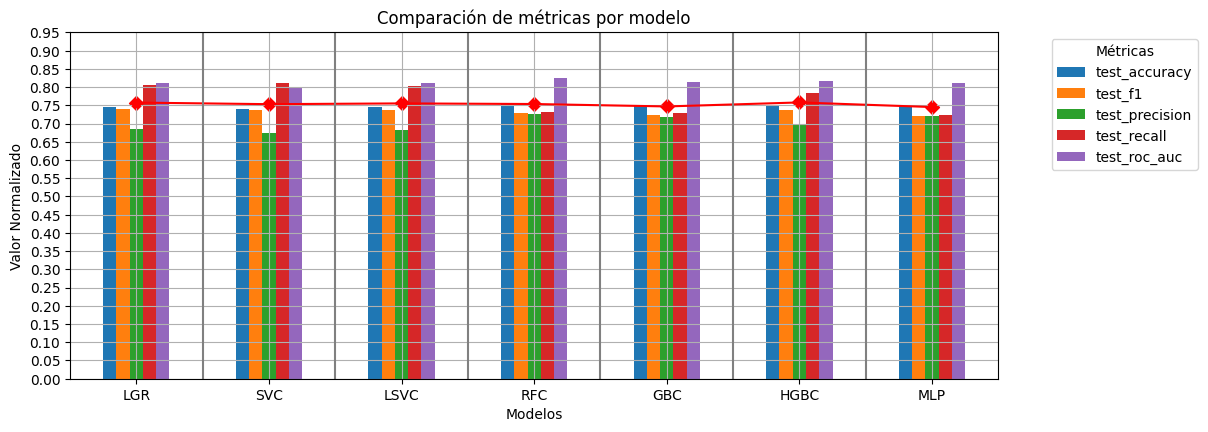

### Iteracion 2.

In [12]:
# --------------------------------------------------------------------------------
# Resultados de optimización por recall
# Factor de ajuste de pesos: 0.3021900884458796
# MODELO  ACCURACY       F1  PRECISION   RECALL  ROC_AUC
#    SVC  0.741082 0.737033   0.674793 0.812126 0.801087
#    LGR  0.746691 0.739966   0.683735 0.806550 0.810928
#   LSVC  0.744355 0.737161   0.682072 0.802371 0.810700
#   HGBC  0.751051 0.740145   0.693809 0.793301 0.815520
#    MLP  0.753856 0.728273   0.718768 0.738228 0.814874
#    RFC  0.756036 0.728519   0.724588 0.732654 0.824751
#    GBC  0.750117 0.722822   0.716890 0.729166 0.812852
# --------------------------------------------------------------------------------
# LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1}, n_jobs=-1, solver='newton-cholesky')
# SVC(C=20, class_weight={False: 0.6978099115541204, True: 1})
# LinearSVC(C=5, class_weight={False: 0.6978099115541204, True: 1})
# RandomForestClassifier(criterion='entropy', n_estimators=2000, n_jobs=-1)
# GradientBoostingClassifier(loss='exponential', n_estimators=500)
# HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204, True: 1}, interaction_cst='pairwise')
# MLPClassifier(activation='tanh', max_iter=1000, solver='sgd')
# --------------------------------------------------------------------------------
# dict_evaluaciones["LGR"].best_params = {'C': 2, 'class_weight': {False: 0.6978099115541204, True: 1}, 'n_jobs': -1, 'solver': 'newton-cholesky'}
# dict_evaluaciones["SVC"].best_params = {'C': 20, 'class_weight': {False: 0.6978099115541204, True: 1}}
# dict_evaluaciones["LSVC"].best_params = {'C': 5, 'class_weight': {False: 0.6978099115541204, True: 1}}
# dict_evaluaciones["RFC"].best_params = {'criterion': 'entropy', 'n_estimators': 2000, 'n_jobs': -1}
# dict_evaluaciones["GBC"].best_params = {'loss': 'exponential', 'max_depth': 3, 'n_estimators': 500}
# dict_evaluaciones["HGBC"].best_params = {'class_weight': {False: 0.6978099115541204, True: 1}, 'interaction_cst': 'pairwise'}
# dict_evaluaciones["MLP"].best_params = {'activation': 'tanh', 'max_iter': 1000, 'solver': 'sgd'}

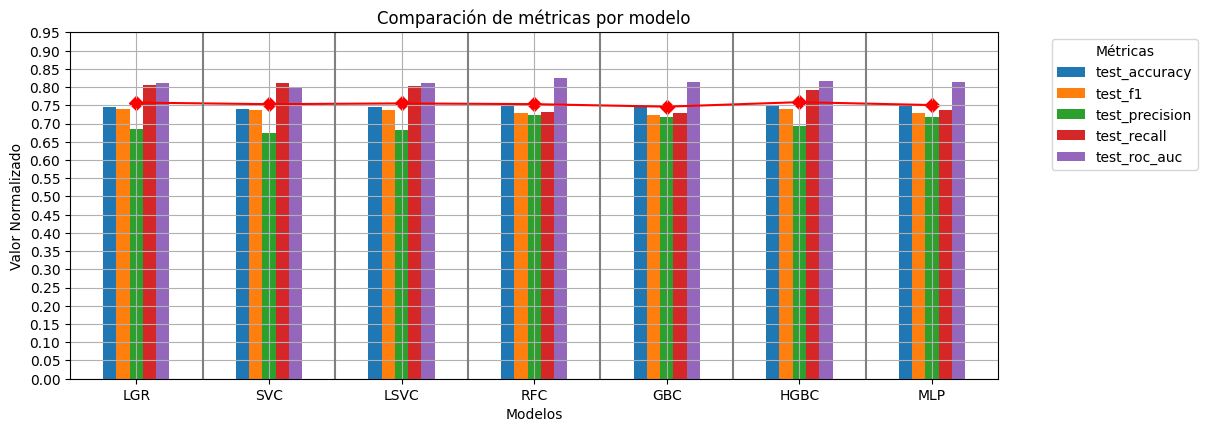

### Iteración 3

In [13]:
# --------------------------------------------------------------------------------
# Resultados de optimización por recall
# Factor de ajuste de pesos: 0.3021900884458796
# MODELO  ACCURACY       F1  PRECISION   RECALL  ROC_AUC
#    LGR  0.746691 0.739966   0.683735 0.806550 0.810928
#    SVC  0.741082 0.737033   0.674793 0.812126 0.801087
#    RFC  0.757127 0.729953   0.725463 0.734745 0.825016
#    GBC  0.750117 0.722052   0.718050 0.726377 0.812609
#   HGBC  0.754636 0.747140   0.692859 0.811076 0.820373
#    MLP  0.752453 0.728663   0.714088 0.744841 0.815015
# --------------------------------------------------------------------------------
# LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1}, n_jobs=-1, solver='newton-cholesky')
# SVC(C=20, class_weight={False: 0.6978099115541204, True: 1})
# RandomForestClassifier(criterion='entropy', n_estimators=10000, n_jobs=-1)
# GradientBoostingClassifier(learning_rate=0.05, loss='exponential', n_estimators=1000)
# HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204, True: 1}, interaction_cst='pairwise', learning_rate=0.05)
# MLPClassifier(activation='tanh', max_iter=1000, solver='sgd')
# --------------------------------------------------------------------------------
# dict_evaluaciones["LGR"].best_params = {'C': 2, 'class_weight': {False: 0.6978099115541204, True: 1}, 'n_jobs': -1, 'solver': 'newton-cholesky'}
# dict_evaluaciones["SVC"].best_params = {'C': 20, 'class_weight': {False: 0.6978099115541204, True: 1}}
# dict_evaluaciones["RFC"].best_params = {'criterion': 'entropy', 'n_estimators': 10000, 'n_jobs': -1}
# dict_evaluaciones["GBC"].best_params = {'learning_rate': 0.05, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 1000}
# dict_evaluaciones["HGBC"].best_params = {'class_weight': {False: 0.6978099115541204, True: 1}, 'interaction_cst': 'pairwise', 'learning_rate': 0.05}
# dict_evaluaciones["MLP"].best_params = {'activation': 'tanh', 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}

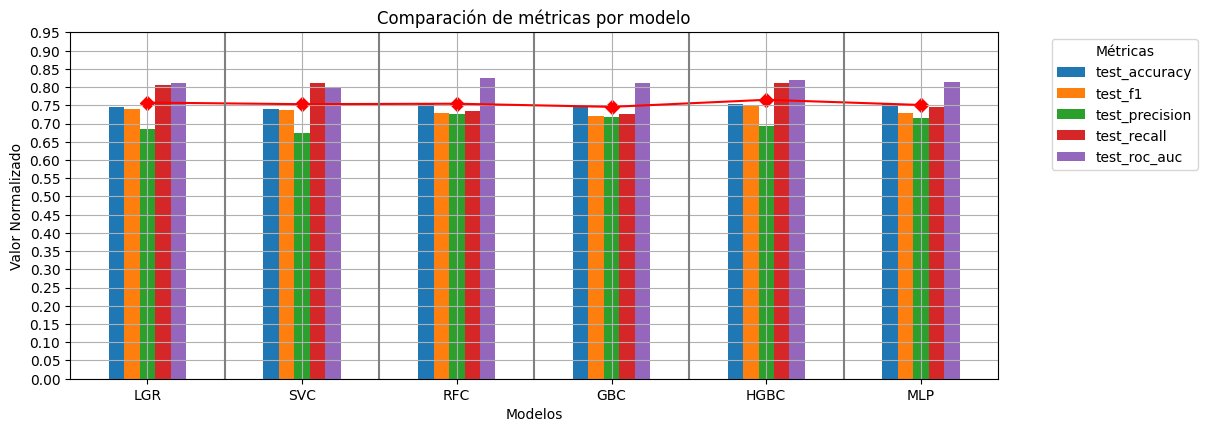

### Iteración 4

In [14]:
# --------------------------------------------------------------------------------
# Resultados de optimización por recall
# Factor de ajuste de pesos: 0.3021900884458796
# MODELO  ACCURACY       F1  PRECISION   RECALL  ROC_AUC
#    LGR  0.746691 0.739966   0.683735 0.806550 0.810928
#    SVC  0.741082 0.737033   0.674793 0.812126 0.801087
#    RFC  0.734851 0.734635   0.664817 0.821186 0.771234
#   HGBC  0.736251 0.717054   0.688848 0.747986 0.801375
#    MLP  0.730490 0.712470   0.680501 0.748354 0.788345
# --------------------------------------------------------------------------------
# LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1}, n_jobs=-1, solver='newton-cholesky')
# SVC(C=20, class_weight={False: 0.6978099115541204, True: 1})
# RandomForestClassifier(ccp_alpha=0.05, class_weight={False: 0.6978099115541204, True: 1}, criterion='entropy', max_features=None, min_samples_leaf=2, n_estimators=10000, n_jobs=-1)
# HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204, True: 1}, interaction_cst='pairwise', learning_rate=0.075, max_features=0.9, max_iter=2000)
# MLPClassifier(activation='tanh', hidden_layer_sizes=(96, 96, 96, 96), learning_rate_init=0.0001, max_iter=5000, momentum=0.5, solver='sgd')
# --------------------------------------------------------------------------------
# dict_evaluaciones["LGR"].best_params = {'C': 2, 'class_weight': {False: 0.6978099115541204, True: 1}, 'n_jobs': -1, 'solver': 'newton-cholesky'}
# dict_evaluaciones["SVC"].best_params = {'C': 20, 'class_weight': {False: 0.6978099115541204, True: 1}}
# dict_evaluaciones["RFC"].best_params = {'ccp_alpha': 0.05, 'class_weight': {False: 0.6978099115541204, True: 1}, 'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 10000, 'n_jobs': -1, 'warm_start': False}
# dict_evaluaciones["HGBC"].best_params = {'class_weight': {False: 0.6978099115541204, True: 1}, 'interaction_cst': 'pairwise', 'learning_rate': 0.075, 'max_features': 0.9, 'max_iter': 2000}
# dict_evaluaciones["MLP"].best_params = {'activation': 'tanh', 'hidden_layer_sizes': (96, 96, 96, 96), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'max_iter': 5000, 'momentum': 0.5, 'solver': 'sgd'}

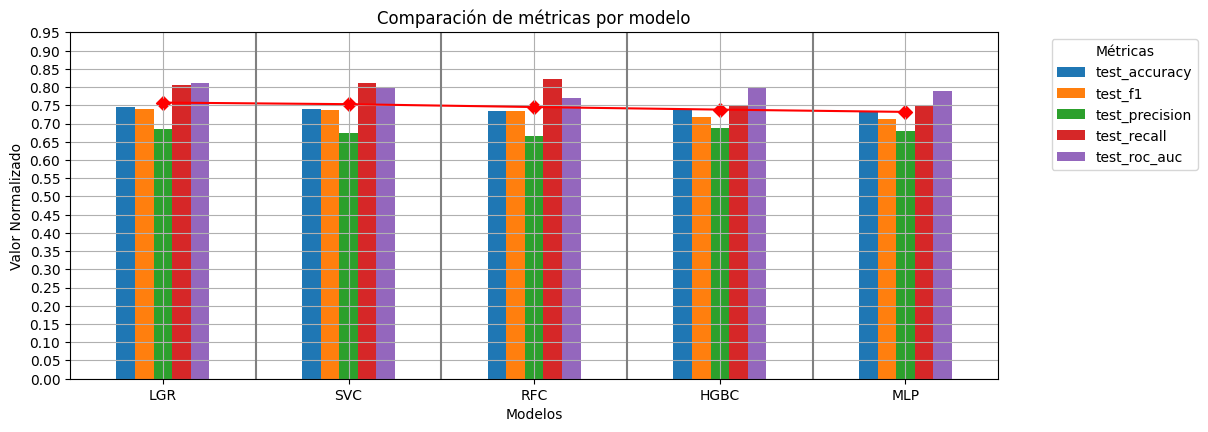

### Iteración 5 - Foco en HGBC sin balanceo

In [ ]:
# --------------------------------------------------------------------------------
# Resultados de optimización por recall
# Factor de ajuste de pesos: 0.3021900884458796
# MODELO  ACCURACY       F1  PRECISION   RECALL  ROC_AUC
#    LGR  0.746533 0.740163   0.684631 0.805635 0.809197
#    SVC  0.741547 0.737146   0.677288 0.808766 0.797851
#    RFC  0.737653 0.736480   0.669716 0.818150 0.764214
#   HGBC  0.765231 0.754072   0.703180 0.813216 0.828478
#    MLP  0.737342 0.719384   0.690344 0.751395 0.794247
# --------------------------------------------------------------------------------
# LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1}, n_jobs=-1, solver='newton-cholesky')
# SVC(C=20, class_weight={False: 0.6978099115541204, True: 1})
# RandomForestClassifier(ccp_alpha=0.05, class_weight={False: 0.6978099115541204, True: 1}, criterion='entropy', max_features=None, min_samples_leaf=2, n_estimators=10000, n_jobs=-1)
# HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204, True: 1}, early_stopping=False, l2_regularization=1, learning_rate=0.015, max_leaf_nodes=63, min_samples_leaf=5)
# MLPClassifier(activation='tanh', hidden_layer_sizes=(96, 96, 96, 96), learning_rate_init=0.0001, max_iter=5000, momentum=0.5, solver='sgd')
# --------------------------------------------------------------------------------
# dict_evaluaciones["LGR"].best_params = {'C': 2, 'class_weight': {False: 0.6978099115541204, True: 1}, 'n_jobs': -1, 'solver': 'newton-cholesky'}
# dict_evaluaciones["SVC"].best_params = {'C': 20, 'class_weight': {False: 0.6978099115541204, True: 1}}
# dict_evaluaciones["RFC"].best_params = {'ccp_alpha': 0.05, 'class_weight': {False: 0.6978099115541204, True: 1}, 'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 10000, 'n_jobs': -1, 'warm_start': False}
# dict_evaluaciones["HGBC"].best_params = {'class_weight': {False: 0.6978099115541204, True: 1}, 'early_stopping': False, 'l2_regularization': 1, 'learning_rate': 0.015, 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 63, 'min_samples_leaf': 5, 'n_iter_no_change': 10, 'scoring': 'loss'}
# dict_evaluaciones["MLP"].best_params = {'activation': 'tanh', 'hidden_layer_sizes': (96, 96, 96, 96), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'max_iter': 5000, 'momentum': 0.5, 'solver': 'sgd'}


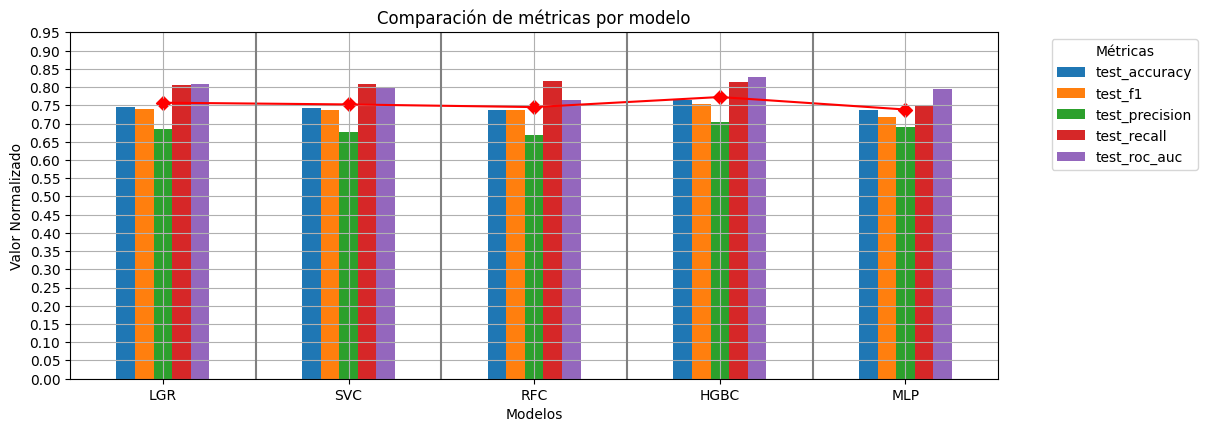

## Búsqueda de hiperparámetros de cada modelo

In [63]:
# Conjuntos de entrenamiento y de prueba
x_train, x_test, y_train, y_test = train_test_split(X, Y)

METRICA = 'recall'
SCORING = ['recall', 'precision', 'f1', 'accuracy']

print('Cálculo de hiperparámetros')
print('-' * 80)
for nombre, evaluacion in dict_evaluaciones.items():
    print(f'{nombre}')
    if evaluacion.isTrained:
        print('Ya entrenado.')
    elif evaluacion.best_params == {}: # Recalcular solo si es nuevo
        # Busqueda exhaustiva
        searchCV = GridSearchCV(
            evaluacion.modelo, evaluacion.param_grid,
            cv=10, scoring=SCORING, refit=METRICA,
            verbose=5,
            #n_jobs=-1, 
        )
        searchCV.fit(x_train, y_train)
        evaluacion.modelo = searchCV.best_estimator_
        evaluacion.best_params = searchCV.best_params_
    else:
        print('Entrenando modelo con hiperparámetros previamente asignados...')
        evaluacion.modelo.set_params(**evaluacion.best_params)
        evaluacion.modelo.fit(x_train, y_train)

    evaluacion.isTrained = True
    print(f'Modelo:', evaluacion.modelo)
    print(evaluacion.modelo.get_params())
    print('-' * 80)

print('Hiperparámetros calculados.')

Cálculo de hiperparámetros
--------------------------------------------------------------------------------
LGR
Ya entrenado.
Modelo: LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1},
                   n_jobs=-1, solver='newton-cholesky')
{'C': 2, 'class_weight': {False: 0.6978099115541204, True: 1}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': -1, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cholesky', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
--------------------------------------------------------------------------------
SVC
Ya entrenado.
Modelo: SVC(C=20, class_weight={False: 0.6978099115541204, True: 1})
{'C': 20, 'break_ties': False, 'cache_size': 200, 'class_weight': {False: 0.6978099115541204, True: 1}, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_

# Validación cruzada (*cross-validation*)

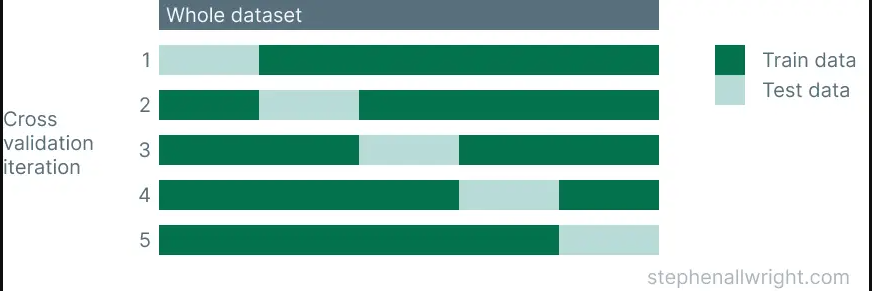

## Evaluación de rendimiento de cada modelo.

In [64]:
print('Rendimiento de cada modelo')
forzar_calculo = False
for nombre, evaluacion in dict_evaluaciones.items():
    print(f'{"-" * 100}')
    print(evaluacion.modelo)
    if forzar_calculo | (not evaluacion.scoresCV):
        print('Calculando...')
        evaluacion.scoresCV = cross_validate(
            estimator=evaluacion.modelo,
            X=x_test, y=y_test, 
            cv=10, 
            scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
            verbose=3,
            n_jobs=4,
        )
        print()

    df_scoresCV = pd.DataFrame(evaluacion.scoresCV)
    print(df_scoresCV.mean())

print('-' * 100)
print('Cross-validation terminado')

Rendimiento de cada modelo
----------------------------------------------------------------------------------------------------
LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1},
                   n_jobs=-1, solver='newton-cholesky')
fit_time          0.035544
score_time        0.008384
test_accuracy     0.746533
test_f1           0.740163
test_precision    0.684631
test_recall       0.805635
test_roc_auc      0.809197
dtype: float64
----------------------------------------------------------------------------------------------------
SVC(C=20, class_weight={False: 0.6978099115541204, True: 1})
fit_time          1.017619
score_time        0.817014
test_accuracy     0.741547
test_f1           0.737146
test_precision    0.677288
test_recall       0.808766
test_roc_auc      0.797851
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForestClassifier(ccp_alpha=0.05,
                       class_we

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    3.1s remaining:    1.3s



fit_time          0.763858
score_time        0.018999
test_accuracy     0.765231
test_f1           0.754072
test_precision    0.703180
test_recall       0.813216
test_roc_auc      0.828478
dtype: float64
----------------------------------------------------------------------------------------------------
MLPClassifier(activation='tanh', hidden_layer_sizes=(96, 96, 96, 96),
              learning_rate_init=0.0001, max_iter=5000, momentum=0.5,
              solver='sgd')
fit_time          11.924351
score_time         0.019306
test_accuracy      0.737342
test_f1            0.719384
test_precision     0.690344
test_recall        0.751395
test_roc_auc       0.794247
dtype: float64
----------------------------------------------------------------------------------------------------
Cross-validation terminado


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.6s finished


# Visualizar métricas de modelos

In [65]:
# Generar tabla de métricas

data = {}
model_names = []
for nombre, evaluacion in dict_evaluaciones.items():
    scores = evaluacion.scoresCV
    model_names.append(nombre)
    data[nombre] = [
        scores['test_accuracy'].mean(),
        scores['test_f1'].mean(),
        scores['test_precision'].mean(),
        scores['test_recall'].mean(),
        scores['test_roc_auc'].mean(),        
    ]

df = pd.DataFrame(
    data,
    index=[
        'test_accuracy',
        'test_f1',
        'test_precision',
        'test_recall',
        'test_roc_auc',
    ]
)

df_normalized = pd.DataFrame(df.T, columns=df.index)

In [66]:
# Visualizar tabla

df_tabla_metricas = df_normalized.reset_index()
df_tabla_metricas.rename(
    columns={
        'index'          : 'MODELO',
        'test_accuracy'  : 'ACCURACY',
        'test_f1'        : 'F1',
        'test_precision' : 'PRECISION',
        'test_recall'    : 'RECALL',
        'test_roc_auc'   : 'ROC_AUC',
    },
    inplace=True,
)

#print(df_tabla_metricas[df_tabla_metricas['MODELO'] == 'RFC'])
print(f'Resultados de optimización por {METRICA}')
print('-' * 80)
print(df_tabla_metricas)

Resultados de optimización por recall
--------------------------------------------------------------------------------
  MODELO  ACCURACY        F1  PRECISION    RECALL   ROC_AUC
0    LGR  0.746533  0.740163   0.684631  0.805635  0.809197
1    SVC  0.741547  0.737146   0.677288  0.808766  0.797851
2    RFC  0.737653  0.736480   0.669716  0.818150  0.764214
3   HGBC  0.765231  0.754072   0.703180  0.813216  0.828478
4    MLP  0.737342  0.719384   0.690344  0.751395  0.794247


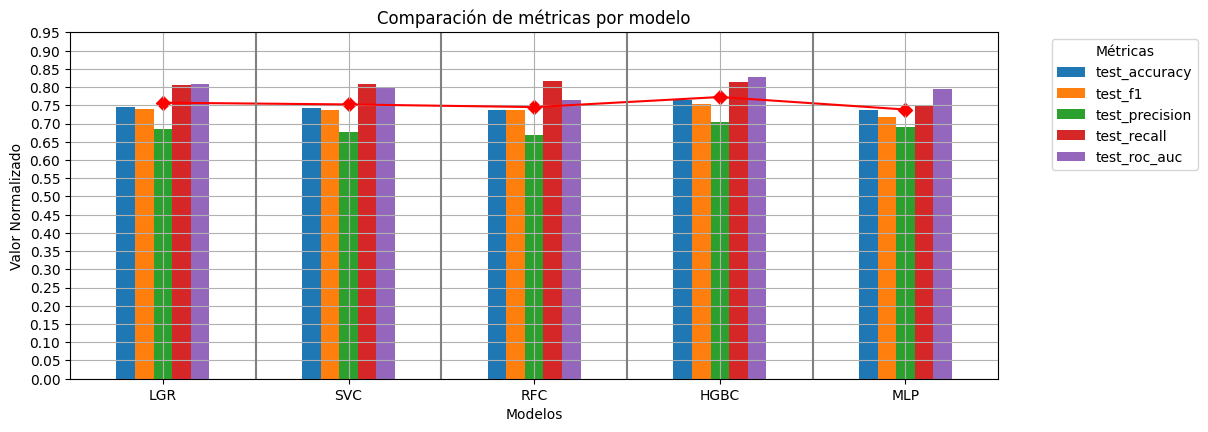

In [67]:
# Visualizar gráfico de barras comparativo


# Crear el gráfico de barras agrupadas por modelo y métricas
ax = df_normalized.plot(kind='bar', figsize=(13, 4))
ax.set_xticklabels(model_names, rotation=0, ha="center")

legend = ax.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.75) # Asegurarse de que la leyenda se ajuste adecuadamente

averages = df_normalized.mean(axis=1)

# Definir los pesos para cada métrica y alcular el promedio ponderado usando los pesos
# weights = np.array([0.1, 0.1, 0.1, 0.2, 0.1])
# averages = df_normalized.dot(weights)

for i, avg in enumerate(averages):
    plt.scatter(i, avg, marker='D', color='red', s=50)

# Trazar la línea que une los puntos promedio
plt.plot(averages.index, averages.values, marker='o', linestyle='-', color='red')

# Agregar líneas entre los promedios de cada grupo
for i in range(1, len(model_names)):
    plt.axvline(x=i-0.5, color='gray', linestyle='-')

plt.yticks(np.arange(0, 1, 0.05))
plt.title('Comparación de métricas por modelo')
plt.xlabel('Modelos')
plt.ylabel('Valor Normalizado')
plt.grid()
plt.show()


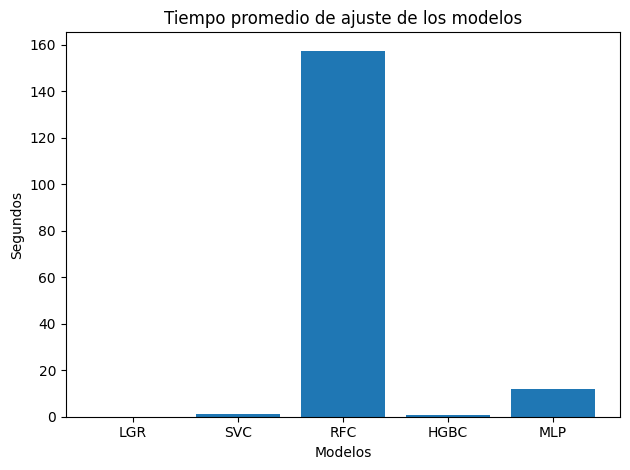

In [68]:
# Visualizar tiempos de ajuste

tiempos = [evaluacion.scoresCV['fit_time'].mean() for evaluacion in dict_evaluaciones.values()]
nombres = dict_evaluaciones.keys()

plt.bar(range(len(nombres)), tiempos)
plt.xticks(range(len(nombres)), nombres)
plt.xlabel('Modelos')
plt.ylabel('Segundos')
plt.title('Tiempo promedio de ajuste de los modelos')
plt.tight_layout()
plt.show()

# Hiperparámetros finales

In [69]:
print('#', '-' * 80)
print(f'# Resultados de optimización por {METRICA}')
print(f'# Factor de ajuste de pesos: {ajuste_prob}')
for linea in df_tabla_metricas.to_string(index=False).split('\n'):
    print(f'# {linea}')
    
print('#', '-' * 80)

for nombre, evaluacion in dict_evaluaciones.items():
    modelo_str = ' '.join([linea.strip() for linea in repr(evaluacion.modelo).split('\n')])
    print(f'# {modelo_str}')
    #print(f'# Full parameters = {evaluacion.modelo.get_params()}')

print('#', '-' * 80)

for nombre, evaluacion in dict_evaluaciones.items():
    print(f'# dict_evaluaciones["{nombre}"].best_params = {evaluacion.best_params}')
    #print('\n#', '-' * 80)


# --------------------------------------------------------------------------------
# Resultados de optimización por recall
# Factor de ajuste de pesos: 0.3021900884458796
# MODELO  ACCURACY       F1  PRECISION   RECALL  ROC_AUC
#    LGR  0.746533 0.740163   0.684631 0.805635 0.809197
#    SVC  0.741547 0.737146   0.677288 0.808766 0.797851
#    RFC  0.737653 0.736480   0.669716 0.818150 0.764214
#   HGBC  0.765231 0.754072   0.703180 0.813216 0.828478
#    MLP  0.737342 0.719384   0.690344 0.751395 0.794247
# --------------------------------------------------------------------------------
# LogisticRegression(C=2, class_weight={False: 0.6978099115541204, True: 1}, n_jobs=-1, solver='newton-cholesky')
# SVC(C=20, class_weight={False: 0.6978099115541204, True: 1})
# RandomForestClassifier(ccp_alpha=0.05, class_weight={False: 0.6978099115541204, True: 1}, criterion='entropy', max_features=None, min_samples_leaf=2, n_estimators=10000, n_jobs=-1)
# HistGradientBoostingClassifier(class_weigh